# Importing the Packages

In [1]:
import numpy as np

In [2]:
import pandas as pd

In [3]:
import matplotlib.pyplot as plt
%matplotlib inline

In [4]:
from pandas import datetime

In [5]:
import seaborn as sns

In [6]:
import math, time

In [7]:
import itertools

In [8]:
import datetime

In [9]:
from operator import itemgetter

In [10]:
from sklearn import preprocessing

In [11]:
from sklearn.metrics import mean_squared_error

In [12]:
from math import sqrt

In [13]:
from keras.models import Sequential

Using TensorFlow backend.


In [14]:
from keras.layers.core import Dense, Dropout, Activation

In [15]:
from keras.layers.recurrent import LSTM

In [16]:
from keras.models import load_model

In [17]:
import keras

In [18]:
import h5py

In [19]:
import requests

In [20]:
import os

# Reading the Data

In [21]:
adjusted = pd.read_csv("./prices-split-adjusted.csv", index_col = 0)
adjusted["adj close"] = adjusted.close # Moving close to the last column
adjusted.drop(['close'], 1, inplace=True) # Moving close to the last column
adjusted.head()

,symbol,open,low,high,volume,adj close
date,,,,,,
2016-01-05,WLTW,123.430000,122.309998,126.250000,2163600.0,125.839996
2016-01-06,WLTW,125.239998,119.940002,125.540001,2386400.0,119.980003
2016-01-07,WLTW,116.379997,114.930000,119.739998,2489500.0,114.949997
2016-01-08,WLTW,115.480003,113.500000,117.440002,2006300.0,116.620003
2016-01-11,WLTW,117.010002,114.089996,117.330002,1408600.0,114.970001


In [22]:
fundamentals = pd.read_csv("./fundamentals.csv")
fundamentals.head()

,Unnamed: 0,Ticker Symbol,Period Ending,Accounts Payable,Accounts Receivable,Add'l income/expense items,After Tax ROE,Capital Expenditures,Capital Surplus,Cash Ratio,...,Total Current Assets,Total Current Liabilities,Total Equity,Total Liabilities,Total Liabilities & Equity,Total Revenue,Treasury Stock,For Year,Earnings Per Share,Estimated Shares Outstanding
0,0,AAL,2012-12-31,3.068000e+09,-222000000.0,-1.961000e+09,23.0,-1.888000e+09,4.695000e+09,53.0,...,7.072000e+09,9.011000e+09,-7.987000e+09,2.489100e+10,1.690400e+10,2.485500e+10,-367000000.0,2012.0,-5.60,3.350000e+08
1,1,AAL,2013-12-31,4.975000e+09,-93000000.0,-2.723000e+09,67.0,-3.114000e+09,1.059200e+10,75.0,...,1.432300e+10,1.380600e+10,-2.731000e+09,4.500900e+10,4.227800e+10,2.674300e+10,0.0,2013.0,-11.25,1.630222e+08
2,2,AAL,2014-12-31,4.668000e+09,-160000000.0,-1.500000e+08,143.0,-5.311000e+09,1.513500e+10,60.0,...,1.175000e+10,1.340400e+10,2.021000e+09,4.120400e+10,4.322500e+10,4.265000e+10,0.0,2014.0,4.02,7.169154e+08
3,3,AAL,2015-12-31,5.102000e+09,352000000.0,-7.080000e+08,135.0,-6.151000e+09,1.159100e+10,51.0,...,9.985000e+09,1.360500e+10,5.635000e+09,4.278000e+10,4.841500e+10,4.099000e+10,0.0,2015.0,11.39,6.681299e+08
4,4,AAP,2012-12-29,2.409453e+09,-89482000.0,6.000000e+05,32.0,-2.711820e+08,5.202150e+08,23.0,...,3.184200e+09,2.559638e+09,1.210694e+09,3.403120e+09,4.613814e+09,6.205003e+09,-27095000.0,2012.0,5.29,7.328355e+07


# Looking for NaN Values

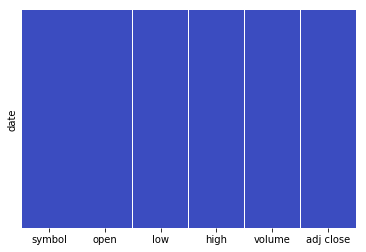

In [23]:
sns.heatmap(adjusted.isnull(),yticklabels=False,cbar=False,cmap='coolwarm')

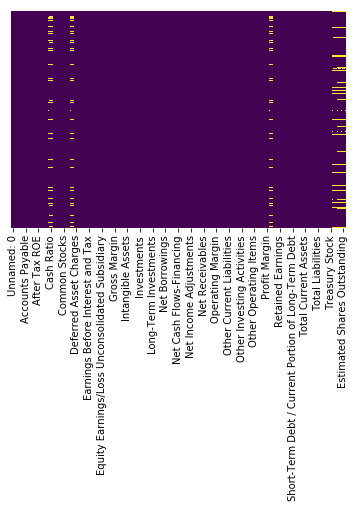

In [24]:
sns.heatmap(fundamentals.isnull(),yticklabels=False,cbar=False,cmap='viridis')

Let's get to work!

# Extracting Symbols from List

In [25]:
symbols = list(set(adjusted.symbol))
len(symbols)

501

In [26]:
symbols[:15] # Example of what is in symbols

['WMB',
 'BAC',
 'EIX',
 'MOS',
 'HSIC',
 'FCX',
 'SPG',
 'IVZ',
 'TRIP',
 'GM',
 'MUR',
 'VRSK',
 'ADSK',
 'OXY',
 'SYK']

# Facebook as an Example

In [27]:
adjusted = adjusted[adjusted.symbol == 'FB']
adjusted.drop(['symbol'],1,inplace=True)
adjusted.head()

,open,low,high,volume,adj close
date,,,,,
2013-01-02,27.440001,27.420000,28.180000,69846400.0,28.000000
2013-01-03,27.879999,27.590000,28.469999,63140600.0,27.770000
2013-01-04,28.010000,27.830000,28.930000,72715400.0,28.760000
2013-01-07,28.690001,28.650000,29.790001,83781800.0,29.420000
2013-01-08,29.510000,28.860001,29.600000,45871300.0,29.059999


# Normalize the Data

In [28]:
def normalize_data(adjusted):
    min_max_scaler = preprocessing.MinMaxScaler()
    adjusted['open'] = min_max_scaler.fit_transform(adjusted.open.values.reshape(-1,1))
    adjusted['high'] = min_max_scaler.fit_transform(adjusted.high.values.reshape(-1,1))
    adjusted['low'] = min_max_scaler.fit_transform(adjusted.low.values.reshape(-1,1))
    adjusted['volume'] = min_max_scaler.fit_transform(adjusted.volume.values.reshape(-1,1))
    adjusted['adj close'] = min_max_scaler.fit_transform(adjusted['adj close'].values.reshape(-1,1))
    return adjusted
adjusted = normalize_data(adjusted)
adjusted.head()

,open,low,high,volume,adj close
date,,,,,
2013-01-02,0.040268,0.043359,0.046101,0.177817,0.046204
2013-01-03,0.044249,0.044911,0.048727,0.159167,0.044120
2013-01-04,0.045426,0.047102,0.052894,0.185797,0.053089
2013-01-07,0.051579,0.054587,0.060683,0.216576,0.059069
2013-01-08,0.058999,0.056504,0.058962,0.111136,0.055807


# Creating the Train Test Split

In [29]:
def load_data(stock, seq_len):
    amount_of_features = len(stock.columns) # 5
    data = stock.as_matrix() 
    sequence_length = seq_len + 1 # index starting from 0
    result = []
    
    for index in range(len(data) - sequence_length): # maxmimum date = lastest date - sequence length
        result.append(data[index: index + sequence_length]) # index : index + 30 days
    
    result = np.array(result)
    row = round(0.9 * result.shape[0]) # 90% split
    train = result[:int(row), :] # 90% date, all features 
    
    x_train = train[:, :-1] 
    y_train = train[:, -1][:,-1]
    
    x_test = result[int(row):, :-1] 
    y_test = result[int(row):, -1][:,-1]

    x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], amount_of_features))
    x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], amount_of_features))  

    return [x_train, y_train, x_test, y_test]

# Building Layers

In [30]:
def build_model(layers):
    d = 0.3
    model = Sequential()
    
    model.add(LSTM(256, input_shape=(layers[1], layers[0]), return_sequences=True))
    model.add(Dropout(d))
        
    model.add(LSTM(256, input_shape=(layers[1], layers[0]), return_sequences=False))
    model.add(Dropout(d))
        
    model.add(Dense(32,kernel_initializer="uniform",activation='relu'))        
    model.add(Dense(1,kernel_initializer="uniform",activation='linear'))
    
    # adam = keras.optimizers.Adam(decay=0.2)
        
    start = time.time()
    model.compile(loss='mse',optimizer='adam', metrics=['accuracy'])
    print("Compilation Time : ", time.time() - start)
    return model

# Training the Model

In [31]:
window = 30
X_train, y_train, X_test, y_test = load_data(adjusted, window)
print (X_train[0], y_train[0])

[[0.04026786 0.0433592  0.0461009  0.17781734 0.04620402]
 [0.04424938 0.044911   0.04872746 0.15916654 0.04412031]
 [0.04542575 0.04710178 0.05289376 0.18579687 0.05308933]
 [0.05157905 0.05458695 0.06068292 0.21657579 0.05906867]
 [0.05899919 0.05650389 0.05896205 0.11113552 0.0558072 ]
 [0.06044702 0.06225468 0.0680192  0.27499939 0.06966842]
 [0.06886255 0.06946601 0.07571779 0.24865691 0.07610073]
 [0.07501584 0.07695116 0.08033692 0.23275236 0.07990577]
 [0.08225502 0.07256961 0.0826012  0.25860393 0.07292989]
 [0.0692245  0.06581469 0.07807263 0.46539263 0.06522921]
 [0.06533344 0.06261982 0.06575491 0.19307636 0.06296431]
 [0.06415709 0.06718394 0.06638891 0.09551967 0.06559158]
 [0.06623834 0.06024646 0.06657007 0.12159375 0.06124298]
 [0.06117093 0.06453674 0.07064577 0.13720182 0.07093676]
 [0.07338702 0.07421268 0.07617064 0.11955868 0.07175213]
 [0.07492535 0.07430396 0.07608007 0.10550007 0.07410763]
 [0.0761922  0.077225   0.08006521 0.13475511 0.07827506]
 [0.0804452  0

/home/atse/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:3: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  This is separate from the ipykernel package so we can avoid doing imports until


In [32]:
model = build_model([5,window,1])

Compilation Time :  0.07312583923339844


In [33]:
model.fit(X_train,y_train,batch_size=512,epochs=100,validation_split=0.1,verbose=1)

Train on 791 samples, validate on 88 samples
Epoch 1/100
791/791 [==============================] - 19s 24ms/step - loss: 0.2220 - acc: 0.0013 - val_loss: 0.6290 - val_acc: 0.0000e+00
Epoch 2/100
791/791 [==============================] - 5s 6ms/step - loss: 0.1805 - acc: 0.0013 - val_loss: 0.3367 - val_acc: 0.0000e+00
Epoch 3/100
791/791 [==============================] - 5s 7ms/step - loss: 0.0642 - acc: 0.0013 - val_loss: 0.0377 - val_acc: 0.0000e+00
Epoch 4/100
791/791 [==============================] - 5s 6ms/step - loss: 0.0522 - acc: 0.0013 - val_loss: 0.0497 - val_acc: 0.0000e+00
Epoch 5/100
791/791 [==============================] - 5s 6ms/step - loss: 0.0368 - acc: 0.0013 - val_loss: 0.1338 - val_acc: 0.0000e+00
Epoch 6/100
791/791 [==============================] - 5s 6ms/step - loss: 0.0210 - acc: 0.0013 - val_loss: 0.1911 - val_acc: 0.0000e+00
Epoch 7/100
791/791 [==============================] - 5s 6ms/step - loss: 0.0296 - acc: 0.0013 - val_loss: 0.1790 - val_acc: 0.000

791/791 [==============================] - 5s 6ms/step - loss: 0.0015 - acc: 0.0013 - val_loss: 0.0016 - val_acc: 0.0000e+00
Epoch 61/100
791/791 [==============================] - 9s 12ms/step - loss: 0.0015 - acc: 0.0013 - val_loss: 0.0013 - val_acc: 0.0000e+00
Epoch 62/100
791/791 [==============================] - 9s 12ms/step - loss: 0.0013 - acc: 0.0013 - val_loss: 0.0014 - val_acc: 0.0000e+00
Epoch 63/100
791/791 [==============================] - 9s 11ms/step - loss: 0.0014 - acc: 0.0013 - val_loss: 0.0011 - val_acc: 0.0000e+00
Epoch 64/100
791/791 [==============================] - 8s 10ms/step - loss: 0.0014 - acc: 0.0013 - val_loss: 0.0012 - val_acc: 0.0000e+00
Epoch 65/100
791/791 [==============================] - 13s 17ms/step - loss: 0.0014 - acc: 0.0013 - val_loss: 0.0013 - val_acc: 0.0000e+00
Epoch 66/100
791/791 [==============================] - 18s 23ms/step - loss: 0.0015 - acc: 0.0013 - val_loss: 0.0012 - val_acc: 0.0000e+00
Epoch 67/100
791/791 [=================

In [34]:
# print(X_test[-1])
diff=[]
ratio=[]
p = model.predict(X_test)
print (p.shape)
# for each data index in test data
for u in range(len(y_test)):
    # pr = prediction day u
    pr = p[u][0]
    # (y_test day u / pr) - 1
    ratio.append((y_test[u]/pr)-1)
    diff.append(abs(y_test[u]- pr))
    # print(u, y_test[u], pr, (y_test[u]/pr)-1, abs(y_test[u]- pr))
    # Last day prediction
    # print(p[-1]) 

(98, 1)


# Denormalize the Data

In [35]:
adj2 = pd.read_csv("./prices-split-adjusted.csv", index_col = 0)
adj2["adj close"] = adj2.close # Moving close to the last column
adj2.drop(['close'], 1, inplace=True) # Moving close to the last column
adj2 = adj2[adj2.symbol == 'FB']
adj2.drop(['symbol'],1,inplace=True)

# Bug fixed at here, please update the denormalize function to this one
def denormalize(adj2, normalized_value): 
    adj2 = adj2['adj close'].values.reshape(-1,1)
    normalized_value = normalized_value.reshape(-1,1)
    
    #return df.shape, p.shape
    min_max_scaler = preprocessing.MinMaxScaler()
    a = min_max_scaler.fit_transform(adj2)
    new = min_max_scaler.inverse_transform(normalized_value)
    return new

newp = denormalize(adj2, p)
newy_test = denormalize(adj2, y_test)

# Creating a Model Score

In [36]:
def model_score(model, X_train, y_train, X_test, y_test):
    trainScore = model.evaluate(X_train, y_train, verbose=0)
    print('Train Score: %.5f MSE (%.2f RMSE)' % (trainScore[0], math.sqrt(trainScore[0])))

    testScore = model.evaluate(X_test, y_test, verbose=0)
    print('Test Score: %.5f MSE (%.2f RMSE)' % (testScore[0], math.sqrt(testScore[0])))
    return trainScore[0], testScore[0]


model_score(model, X_train, y_train, X_test, y_test)

Train Score: 0.00078 MSE (0.03 RMSE)
Test Score: 0.00136 MSE (0.04 RMSE)


(0.0007798585050609026, 0.0013630808118287692)

# Creating Visualizations

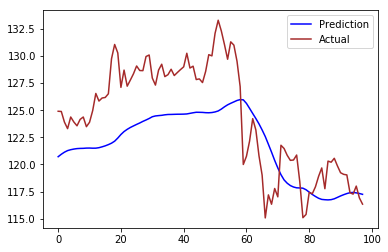

In [37]:
import matplotlib.pyplot as plt2

plt2.plot(newp,color='blue', label='Prediction')
plt2.plot(newy_test,color='brown', label='Actual')
plt2.legend(loc='best')
plt2.show()